In [1]:
import pandas as pd
import numpy as np
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import seaborn as sns
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set(style="whitegrid")
# warnings.filterwarnings("ignore")

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
excel_path = '/kaggle/input/glomeruloscelorosis/public.csv'
df = pd.read_csv(excel_path)
print(df.head())

                                                name  ground truth
0  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
1  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
2  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
3  S-2006-005094_PAS_1of2_64552732435c92704a3d37c...             0
4  S-2006-005094_PAS_1of2_64552732435c92704a3d37d...             0


In [4]:
#path to both the folders
folder1_path = '/kaggle/input/glomeruloscelorosis/globally_sclerotic_glomeruli/'  
folder2_path = '/kaggle/input/glomeruloscelorosis/non_globally_sclerotic_glomeruli'
img_paths = [folder1_path, folder2_path]

#adding a new column to the dataframe that contains the path to the image and it's name
df['image_path'] = df['name'].apply(
        lambda x: os.path.join(folder1_path, x) if os.path.exists(os.path.join(folder1_path, x))
        else os.path.join(folder2_path, x) if os.path.exists(os.path.join(folder2_path, x))
        else None
    )


In [5]:
df.info()
# df['ground truth'] = df['ground truth'].astype(str)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          5758 non-null   object
 1   ground truth  5758 non-null   int64 
 2   image_path    5758 non-null   object
dtypes: int64(1), object(2)
memory usage: 135.1+ KB


In [6]:
# finding the index of the image that is truncated and dropping it
index = df[df['name'] == 'S-2002-007461_PAS_1of2_64542ed5435c92704a34915d.png'].index[0]
print(index)
df.drop(4574,inplace=True)
df.reset_index(inplace=True)

4574


In [7]:
# Load features and labels
features = np.load('/kaggle/input/features-labels/features.npy')
labels = np.load('/kaggle/input/features-labels/labels.npy')


In [8]:
df.drop('index',axis=1,inplace=True)
df.head()

,name,ground truth,image_path
0,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...
1,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...
2,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...
3,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...
4,S-2006-005094_PAS_1of2_64552732435c92704a3d37d...,0,/kaggle/input/glomeruloscelorosis/non_globally...


In [9]:
df_array = pd.DataFrame(features, columns=[f'f{i}' for i in range(1,12)])  #converting the features.npy file into a dataframe
df = pd.concat([df, df_array], ignore_index=True,axis=1)        #concatenating the df_array and df dataframes
print(df.shape)


(5757, 14)


In [10]:
#renaming the columns for better interpretability
df.rename(columns={0: 'name', 1: 'ground truth',2:'image_path'}, inplace=True)
df.rename(columns={3: 'f1', 4: 'f2',5:'f3',6:'f4',7:'f5',8:'f6',9:'f7',10:'f8',11:'f9',12:'f10',13:'f11'}, inplace=True)

#normalizing some of the columns
scaler = MinMaxScaler()
df[['f1', 'f2','f5','f6','f7']] = scaler.fit_transform(df[['f1', 'f2','f5','f6','f7']])
df.head()


,name,ground truth,image_path,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
0,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...,0.135396,0.172140,0.613532,0.460757,0.540810,0.679090,0.306279,7.813146,0.306785,0.072380,0.980402
1,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...,0.106163,0.262284,0.526870,0.355202,0.375573,0.677076,0.302721,9.253420,0.155894,0.016113,0.967392
2,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...,0.160521,0.065619,1.155963,0.742209,0.371169,0.655720,0.197254,7.287852,0.222909,0.036135,0.982127
3,S-2006-005094_PAS_1of2_64552732435c92704a3d37c...,0,/kaggle/input/glomeruloscelorosis/non_globally...,0.027140,0.088588,0.787671,0.285193,0.372979,0.657166,0.320763,9.172040,0.175850,0.021963,0.970531
4,S-2006-005094_PAS_1of2_64552732435c92704a3d37d...,0,/kaggle/input/glomeruloscelorosis/non_globally...,0.093153,0.319723,0.902439,0.243723,0.396571,0.670934,0.291144,8.801991,0.179107,0.022915,0.970858


In [11]:
df.shape

(5757, 14)

In [12]:
nan_rows = df[df.isna().any(axis=1)]

# Display rows containing NaN values
print(nan_rows)

Empty DataFrame
Columns: [name, ground truth, image_path, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11]
Index: []


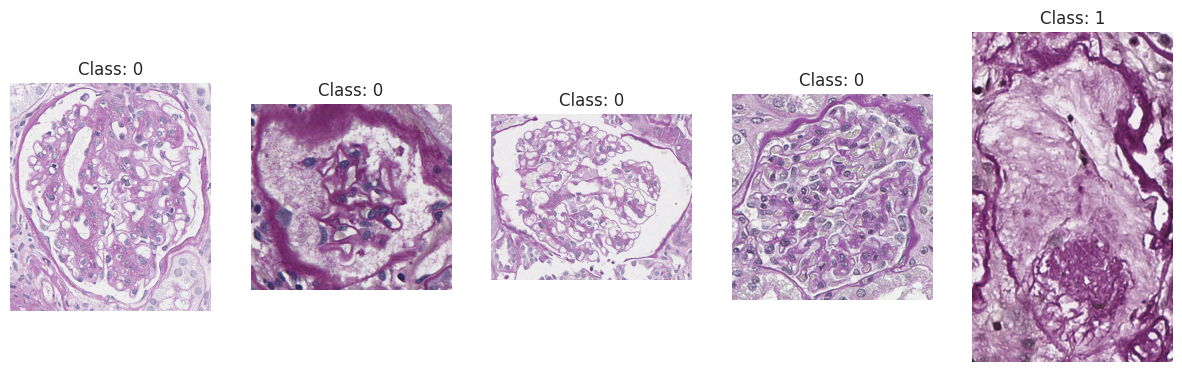

In [13]:
#function to display random images from dataset for visualization
def display_random_images(df, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        random_idx = random.randint(0, len(df) - 1)
        image_path = df.iloc[random_idx]['image_path']
        class_id = df.iloc[random_idx]['ground truth']
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Class: {class_id}')
    plt.show()

# Display random images
display_random_images(df)

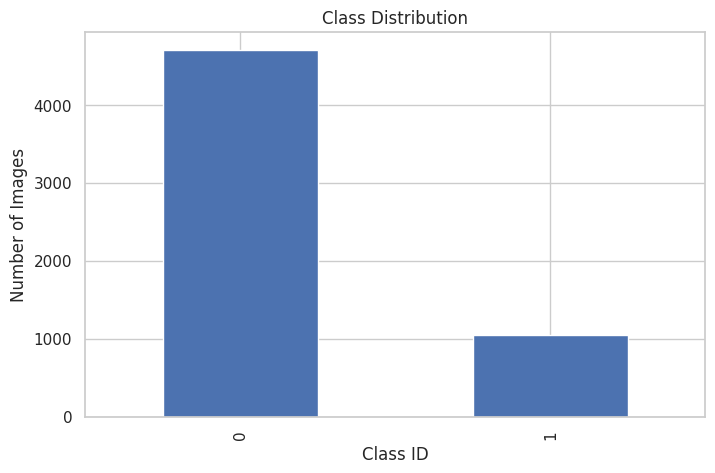

In [14]:
#plotting a graph to visualize the distribution of classes
df['ground truth'].value_counts().plot(kind='bar', figsize=(8, 5), title="Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

In [15]:
df['ground truth'].value_counts()

ground truth
0    4704
1    1053
Name: count, dtype: int64

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim

#defining the model that will take both the images and features as input, by extending the nn.Module class
class MultiInputModel(nn.Module):
    def __init__(self, image_input_shape, feature_input_shape):
        super(MultiInputModel, self).__init__()
        
        # Image input branch 
        self.image_fc = nn.Sequential(
            nn.Flatten(),
        )
        
        # Feature input branch 
        self.feature_fc = nn.Sequential(
            nn.Linear(feature_input_shape, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Combine both branches
        self.combined_fc = nn.Sequential(
            nn.Linear(224 * 224 * 3 + 64, 64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Output layer (for binary classification)
        self.output_fc = nn.Sequential(
            nn.Linear(64, 2),
            nn.Sigmoid()
        )
    
    def forward(self, image_input, feature_input):
        x = self.image_fc(image_input)  # Process the image input
        y = self.feature_fc(feature_input)  # Process the feature input
        
        # Concatenate both branches
        combined = torch.cat((x, y), dim=1)
        
        # Forward pass through the combined layers
        z = self.combined_fc(combined)
        
        # Output prediction
        output = self.output_fc(z)
        
        return output

image_input_shape = (224, 224, 3)  #shape for images
feature_input_shape = 11  #number of features for the feature input

# Instantiate the model
model = MultiInputModel(image_input_shape, feature_input_shape)

# Print model summary 
print(model)


MultiInputModel(
  (image_fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
  )
  (feature_fc): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (combined_fc): Sequential(
    (0): Linear(in_features=150592, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (output_fc): Sequential(
    (0): Linear(in_features=64, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


In [17]:

batch_size=32
target_size=(224, 224)


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, df, target_size=(224, 224), augment=False):
        self.df = df
        self.target_size = target_size
        
        #transformations
        self.transform = transforms.Compose([
            transforms.Resize(self.target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        #implementing data augmentation to increase the number of samples
        if augment:
            self.augment_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(30),
                self.random_zoom(),
                self.transform
            ])
        else:
            self.augment_transform = self.transform
    
    def random_zoom(self):
        """ Custom zoom using RandomAffine """
        return transforms.RandomAffine(
            degrees=0,  # No rotation
            translate=None,  # No translation
            scale=(0.8, 1.2)  # Random scaling (zoom in or out)
        )
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img = Image.open(row['image_path'])
        
        # Convert RGBA to RGB if necessary
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        
        # Apply augmentations if specified
        img = self.augment_transform(img)
        
        # Extract textual features
        feature_values = row[['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values
        feature_values = np.array(feature_values, dtype=np.float32)
        
        # Extract label
        label = float(row['ground truth'])
        
        return img, feature_values, label

# Split data (80% train, 20% test, then 20% validation from train)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Create dataset instances
train_dataset = CustomDataset(train_df, target_size=(224, 224), augment=True)
val_dataset = CustomDataset(val_df, target_size=(224, 224), augment=False)
test_dataset = CustomDataset(test_df, target_size=(224, 224), augment=False)

# Create DataLoader instances
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#loop over DataLoader
for images, features, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch features shape: {features.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break  


Training samples: 3684
Validation samples: 921
Test samples: 1152
Batch images shape: torch.Size([32, 3, 224, 224])
Batch features shape: torch.Size([32, 11])
Batch labels shape: torch.Size([32])


In [19]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm

# Model, Loss, Optimizer
model = MultiInputModel((224, 224, 3),(11))  # Replace with your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
total_samples = 4704 + 1054

#weights for weighted loss function
class_weights = [
    total_samples / 4704,
    total_samples / 1054,

    ]
class_weights = torch.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
# criterion = torch.nn.CrossEntropyLoss()

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define Precision and Recall calculations
def calculate_metrics(y_true, y_pred):
    y_pred_binary = torch.argmax(y_pred, dim=1).cpu().detach().numpy()  # Get the class with highest probability
    
    # Convert y_true to numpy
    y_true = y_true.cpu().numpy()
    
    # Calculate precision and recall
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    accuracy=accuracy_score(y_true,y_pred_binary)
    
    return accuracy,precision, recall

# Training Loop with EarlyStopping and ModelCheckpoint
best_val_loss = 100.00
patience = 5  # Early stopping patience (number of epochs without improvement)
patience_counter = 0

for epoch in range(30):
    model.train()
    train_loss = 0
    all_labels = []
    all_preds = []

    # Training Step
    for images, features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{50}", leave=False):
        images, features, labels = images.to(device).float(), features.to(device).float(), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images, features) 
        
        loss = criterion(outputs, labels)  
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        train_loss += loss.item()

        all_labels.append(labels)
        all_preds.append(outputs)
        # print(outputs)

    # Compute training loss and metrics
    train_loss /= len(train_loader)
    train_loss=round(train_loss,3)
    all_labels = torch.cat(all_labels)
    # print(all_preds)
    all_preds = torch.cat(all_preds)
    train_accuracy, train_precision, train_recall = calculate_metrics(all_labels, all_preds)
    
    # Validation Step
    model.eval()
    val_loss = 0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, features, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, features, labels = images.to(device).float(), features.to(device).float(), labels.to(device).long()

            outputs = model(images, features) 
            # outputs=outputs.reshape(batch_size)
            # outputs=outputs.long()
            loss = criterion(outputs, labels)  
            
            val_loss += loss.item()

            all_labels.append(labels)
            all_preds.append(outputs)
            
    # Compute validation loss and metrics
    val_loss /= len(val_loader)
    val_loss=round(val_loss,3)
    all_labels = torch.cat(all_labels)
    all_preds = torch.cat(all_preds)
    val_accuracy, val_precision, val_recall = calculate_metrics(all_labels, all_preds)

    print(f"Epoch {epoch+1}/{30} - Train Loss: {train_loss:.3f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Accuracy:{train_accuracy}")
    print(f"Epoch {epoch+1}/{30} - Val Loss: {val_loss:.3f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val Accuracy:{val_accuracy}")
    
    # Checkpoint and EarlyStopping
    print(val_loss,best_val_loss)
    if float(val_loss) < float(best_val_loss):
        best_val_loss = float(val_loss)
        print(best_val_loss)
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save model checkpoint
        print("Validation loss improved, model saved!")
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"Early stopping after {epoch+1} epochs.")
    #         break


cpu


Epoch 1/30 - Train Loss: 0.683, Train Precision: 0.4070, Train Recall: 0.3392, Accuracy:0.7855591748099892
Epoch 1/30 - Val Loss: 0.668, Val Precision: 0.5439, Val Recall: 0.3924, Val Accuracy:0.8393051031487514
0.668 100.0
0.668
Validation loss improved, model saved!


Epoch 2/30 - Train Loss: 0.670, Train Precision: 0.3878, Train Recall: 0.4547, Accuracy:0.7654723127035831
Epoch 2/30 - Val Loss: 0.628, Val Precision: 0.3484, Val Recall: 0.6835, Val Accuracy:0.7263843648208469
0.628 0.668
0.628
Validation loss improved, model saved!


Epoch 3/30 - Train Loss: 0.665, Train Precision: 0.3379, Train Recall: 0.4298, Accuracy:0.737785016286645
Epoch 3/30 - Val Loss: 0.637, Val Precision: 0.2974, Val Recall: 0.8734, Val Accuracy:0.6243213897937026
0.637 0.628


Epoch 4/30 - Train Loss: 0.683, Train Precision: 0.2592, Train Recall: 0.6506, Accuracy:0.5898479913137894
Epoch 4/30 - Val Loss: 0.636, Val Precision: 0.4747, Val Recall: 0.5949, Val Accuracy:0.8175895765472313
0.636 0.628


Epoch 5/30 - Train Loss: 0.660, Train Precision: 0.4306, Train Recall: 0.3947, Accuracy:0.7907166123778502
Epoch 5/30 - Val Loss: 0.670, Val Precision: 0.7674, Val Recall: 0.2089, Val Accuracy:0.8534201954397395
0.67 0.628


Epoch 6/30 - Train Loss: 0.667, Train Precision: 0.6203, Train Recall: 0.2412, Accuracy:0.8317046688382194
Epoch 6/30 - Val Loss: 0.669, Val Precision: 0.7347, Val Recall: 0.2278, Val Accuracy:0.8534201954397395
0.669 0.628


Epoch 7/30 - Train Loss: 0.670, Train Precision: 0.6067, Train Recall: 0.2120, Accuracy:0.8281758957654723
Epoch 7/30 - Val Loss: 0.699, Val Precision: 0.8261, Val Recall: 0.1203, Val Accuracy:0.8447339847991314
0.699 0.628


Epoch 8/30 - Train Loss: 0.678, Train Precision: 0.5038, Train Recall: 0.1915, Accuracy:0.8148751357220413
Epoch 8/30 - Val Loss: 0.763, Val Precision: 0.8182, Val Recall: 0.1139, Val Accuracy:0.8436482084690554
0.763 0.628


Epoch 9/30 - Train Loss: 0.669, Train Precision: 0.3473, Train Recall: 0.3889, Accuracy:0.750814332247557
Epoch 9/30 - Val Loss: 0.673, Val Precision: 0.8214, Val Recall: 0.1456, Val Accuracy:0.8479913137893594
0.673 0.628


Epoch 10/30 - Train Loss: 0.666, Train Precision: 0.4806, Train Recall: 0.2895, Accuracy:0.8099891422366993
Epoch 10/30 - Val Loss: 0.668, Val Precision: 0.7556, Val Recall: 0.2152, Val Accuracy:0.8534201954397395
0.668 0.628


Epoch 11/30 - Train Loss: 0.661, Train Precision: 0.4818, Train Recall: 0.3289, Accuracy:0.8097176981541803
Epoch 11/30 - Val Loss: 0.648, Val Precision: 0.3251, Val Recall: 0.7468, Val Accuracy:0.6905537459283387
0.648 0.628


Epoch 12/30 - Train Loss: 0.654, Train Precision: 0.4491, Train Recall: 0.4254, Accuracy:0.7964169381107492
Epoch 12/30 - Val Loss: 0.648, Val Precision: 0.6477, Val Recall: 0.3608, Val Accuracy:0.8566775244299675
0.648 0.628


Epoch 13/30 - Train Loss: 0.655, Train Precision: 0.5714, Train Recall: 0.3216, Accuracy:0.8292616720955484
Epoch 13/30 - Val Loss: 0.656, Val Precision: 0.6429, Val Recall: 0.2848, Val Accuracy:0.8501628664495114
0.656 0.628


Epoch 14/30 - Train Loss: 0.659, Train Precision: 0.3717, Train Recall: 0.4868, Accuracy:0.751900108577633
Epoch 14/30 - Val Loss: 0.630, Val Precision: 0.4831, Val Recall: 0.5443, Val Accuracy:0.8219326818675353
0.63 0.628


Epoch 15/30 - Train Loss: 0.654, Train Precision: 0.4461, Train Recall: 0.4357, Accuracy:0.7947882736156352
Epoch 15/30 - Val Loss: 0.657, Val Precision: 0.6429, Val Recall: 0.3418, Val Accuracy:0.8545059717698155
0.657 0.628


Epoch 16/30 - Train Loss: 0.654, Train Precision: 0.5290, Train Recall: 0.3596, Accuracy:0.8216612377850163
Epoch 16/30 - Val Loss: 0.665, Val Precision: 0.7111, Val Recall: 0.2025, Val Accuracy:0.8490770901194354
0.665 0.628


Epoch 17/30 - Train Loss: 0.667, Train Precision: 0.5135, Train Recall: 0.2778, Accuracy:0.8170466883821933
Epoch 17/30 - Val Loss: 0.654, Val Precision: 0.6629, Val Recall: 0.3734, Val Accuracy:0.8599348534201955
0.654 0.628


Epoch 18/30 - Train Loss: 0.651, Train Precision: 0.4586, Train Recall: 0.4050, Accuracy:0.8007600434310532
Epoch 18/30 - Val Loss: 0.649, Val Precision: 0.6316, Val Recall: 0.3797, Val Accuracy:0.8555917480998915
0.649 0.628


Epoch 19/30 - Train Loss: 0.659, Train Precision: 0.5680, Train Recall: 0.2749, Accuracy:0.8265472312703583
Epoch 19/30 - Val Loss: 0.659, Val Precision: 0.6909, Val Recall: 0.2405, Val Accuracy:0.8512486427795874
0.659 0.628


Epoch 20/30 - Train Loss: 0.654, Train Precision: 0.5423, Train Recall: 0.3187, Accuracy:0.8235613463626493
Epoch 20/30 - Val Loss: 0.661, Val Precision: 0.6923, Val Recall: 0.2278, Val Accuracy:0.8501628664495114
0.661 0.628


Epoch 21/30 - Train Loss: 0.651, Train Precision: 0.4730, Train Recall: 0.4225, Accuracy:0.8053745928338762
Epoch 21/30 - Val Loss: 0.641, Val Precision: 0.4130, Val Recall: 0.6456, Val Accuracy:0.7817589576547231
0.641 0.628


Epoch 22/30 - Train Loss: 0.732, Train Precision: 0.2286, Train Recall: 0.7325, Accuracy:0.49131378935939196
Epoch 22/30 - Val Loss: 0.802, Val Precision: 0.1892, Val Recall: 0.9937, Val Accuracy:0.2681867535287731
0.802 0.628


Epoch 23/30 - Train Loss: 0.712, Train Precision: 0.2452, Train Recall: 0.6579, Accuracy:0.5605320304017373
Epoch 23/30 - Val Loss: 0.683, Val Precision: 0.2743, Val Recall: 0.9114, Val Accuracy:0.5711183496199783
0.683 0.628


Epoch 24/30 - Train Loss: 0.667, Train Precision: 0.3353, Train Recall: 0.5029, Accuracy:0.7225841476655809
Epoch 24/30 - Val Loss: 0.632, Val Precision: 0.5263, Val Recall: 0.5063, Val Accuracy:0.8371335504885994
0.632 0.628


Epoch 25/30 - Train Loss: 0.653, Train Precision: 0.3961, Train Recall: 0.5044, Accuracy:0.7652008686210641
Epoch 25/30 - Val Loss: 0.667, Val Precision: 0.3075, Val Recall: 0.8291, Val Accuracy:0.6503800217155266
0.667 0.628


Epoch 26/30 - Train Loss: 0.754, Train Precision: 0.2237, Train Recall: 0.9079, Accuracy:0.3979370249728556
Epoch 26/30 - Val Loss: 0.656, Val Precision: 0.4593, Val Recall: 0.3924, Val Accuracy:0.8165038002171553
0.656 0.628


Epoch 27/30 - Train Loss: 0.707, Train Precision: 0.2591, Train Recall: 0.6944, Accuracy:0.5746471226927253
Epoch 27/30 - Val Loss: 0.656, Val Precision: 0.5253, Val Recall: 0.3291, Val Accuracy:0.8338762214983714
0.656 0.628


Epoch 28/30 - Train Loss: 0.701, Train Precision: 0.2694, Train Recall: 0.6915, Accuracy:0.5944625407166124
Epoch 28/30 - Val Loss: 0.650, Val Precision: 0.5000, Val Recall: 0.3924, Val Accuracy:0.8284473398479913
0.65 0.628


Epoch 29/30 - Train Loss: 0.685, Train Precision: 0.2914, Train Recall: 0.6404, Accuracy:0.6441368078175895
Epoch 29/30 - Val Loss: 0.646, Val Precision: 0.5000, Val Recall: 0.4177, Val Accuracy:0.8284473398479913
0.646 0.628


Epoch 30/30 - Train Loss: 0.691, Train Precision: 0.2794, Train Recall: 0.7924, Accuracy:0.5819761129207384
Epoch 30/30 - Val Loss: 0.640, Val Precision: 0.4253, Val Recall: 0.5949, Val Accuracy:0.7926167209554832
0.64 0.628


In [20]:
# Test evaluation
test_loss = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, features, labels in tqdm(test_loader, desc="Test Evaluation", leave=False):
        images, features, labels = images.to(device).float(), features.to(device).float(), labels.to(device).long()

        outputs = model(images, features)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        all_labels.append(labels)
        all_preds.append(outputs)

# Compute test loss and metrics
test_loss /= len(test_loader)
all_labels = torch.cat(all_labels)
all_preds = torch.cat(all_preds)
test_accuracy, test_precision, test_recall = calculate_metrics(all_labels, all_preds)

# Print test results
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Test Loss: 0.639
Test Accuracy: 0.7821
Test Precision: 0.4333
Test Recall: 0.6161


In [21]:
# Save predictions and true labels
import pandas as pd

predictions = torch.argmax(all_preds, dim=1).cpu().numpy()
true_labels = all_labels.cpu().numpy()

results = pd.DataFrame({'True': true_labels, 'Predicted': predictions})
results.to_csv('test_results.csv', index=False)
print("Test results saved to 'test_results.csv'.")


Test results saved to 'test_results.csv'.
